<a href="https://colab.research.google.com/github/CyJavac/CIENCIA_DATOS_2025/blob/main/Apikey_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-6430e375-f103-4aad-8ffa-aa00706b3e16"
RIOT_ID = "Arumah"
TAG_LINE = "Aruh"
HEADERS = {"X-Riot-Token": API_KEY}

In [4]:
!GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `GET https://<region>.api.riotgames.com/lol/match/v5/matches/<matchId>'


In [5]:
# Obtener el Puuid del jugador
def get_puuid(game_name, tag_line):
    url = f"https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()["puuid"]
    except Exception as e:
        print(f"Error al obtener PUUID: {str(e)}")
        return None

# Obtener Historial de las partidas
def get_match_history(puuid, count=10, start=0):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start={start}&count={count}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error al obtener historial: {str(e)}")
        return None

In [6]:
# Datos de la partida
def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f" Error en match {match_id}: {str(e)}")
        return None


# --- Obtener datos extendidos ---
def get_extended_data(match_id, puuid):
    match_data = get_match_details(match_id)
    if not match_data:
        return None

    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)

        return {
            # Datos base
            "puuid": puuid,
            "summoner_id": participant["summonerId"],
            "summoner_name": participant["summonerName"],
            # "date": match_data["info"]["gameCreation"],
            "date": datetime.fromtimestamp(match_data["info"]["gameCreation"] / 1000).strftime('%Y-%m-%d %H:%M:%S'),
            # "region": match_data["info"]["gameMode"],
            "game_mode": match_data["info"]["gameMode"],
            "game_id": match_data["metadata"]["matchId"],
            "match_id": match_id,
            "champion": participant["championName"],
            "win": participant["win"],
            "kills": participant["kills"],
            "deaths": participant["deaths"],
            "assists": participant["assists"],
            "kda": round((participant["kills"] + participant["assists"]) / max(1, participant["deaths"]), 2),
            "cs": participant["totalMinionsKilled"] + participant["neutralMinionsKilled"],
            "vision_score": participant["visionScore"],
            "gold_earned": participant["goldEarned"],
            "gold_spent": participant["goldSpent"],
            "total_damage_dealt": participant["totalDamageDealtToChampions"],
            "total_damage_taken": participant["totalDamageTaken"],
            "magic_damage_dealt": participant["magicDamageDealtToChampions"],
            "physical_damage_dealt": participant["physicalDamageDealtToChampions"],
            "true_damage_dealt": participant["trueDamageDealtToChampions"],
            "timeCCingOthers": participant["timeCCingOthers"],
            "total_minions_killed": participant["totalMinionsKilled"],
            "largest_killing_spree": participant["largestKillingSpree"],
            "largest_multi_kill": participant["largestMultiKill"],
            "killing_sprees": participant["killingSprees"],
            "perks": participant["perks"],
            "longest_time_spent_living": participant["longestTimeSpentLiving"],
            "total_units_healed": participant["totalUnitsHealed"],
            "totalTimeSpentDead": participant["totalTimeSpentDead"],
            "vision_wards_bought_in_game": participant["visionWardsBoughtInGame"],
            "game_duration": match_data["info"]["gameDuration"] // 60,
            "queue_id": match_data["info"]["queueId"],
            "team_position": participant["teamPosition"],
            "lane": participant["lane"],
            "role": participant["role"],
            "level": participant["champLevel"],
            "game_version": match_data["info"]["gameVersion"],
            "map_id": match_data["info"]["mapId"],
            "game_name": match_data["info"]["gameName"],
            "game_creation": match_data["info"]["gameCreation"],
            "game_version": match_data["info"]["gameVersion"],
            "game_type": match_data["info"]["gameType"],
            "platform_id": match_data["info"]["platformId"],
            "participants": match_data["info"]["participants"],
            "teams": match_data["info"]["teams"],
            "items": [participant[f"item{i}"] for i in range(7)],
            "summoner_spells": [participant["summoner1Id"], participant["summoner2Id"]],
            "damage_to_champs": participant["totalDamageDealtToChampions"],
            "damage_taken": participant["totalDamageTaken"],
            "dragons_killed": participant["dragonKills"],
            "barons_killed": participant["baronKills"],
            "turret_kills": participant["turretKills"],
            "wards_placed": participant["wardsPlaced"],
            "wards_destroyed": participant["wardsKilled"],
            "vision_score_per_min": participant["visionScore"] / max(1, (match_data["info"]["gameDuration"] / 60)),
        }
    except Exception as e:
        print(f"Error procesando {match_id}: {str(e)}")
        return None

In [7]:
# --- EJECUCIÓN PRINCIPAL ---
print("Iniciando extracción...")
puuid = get_puuid(RIOT_ID, TAG_LINE)

if puuid:
    print(f"PUUID obtenido: {puuid}")
    match_ids = get_match_history(puuid, count=100)  # Deberia de poderse aumentar el count, pero tal parece que riot solo guarda las ultimas 100 partidas

    if match_ids:
        all_matches = []
        for match_id in match_ids:
            match_data = get_extended_data(match_id, puuid)
            if match_data:
                all_matches.append(match_data)
            sleep(1.5)  # Respeta el rate limit

        df = pd.DataFrame(all_matches)

        # Guardar en Excel
        filename = f"lol_data_{RIOT_ID}.xlsx"
        df.to_excel(filename, index=False)
        print(f"Datos guardados en '{filename}'")

        # Descargar automáticamente en Colab
        try:
            from google.colab import files
            files.download(filename)
            print("Archivo descargado!")
        except:
            print("Ejecutando localmente - revisa el archivo en tu directorio")
    else:
        print(" No se encontraron partidas")
else:
    print("No se pudo obtener PUUID - Verifica:")
    print(f"- API Key (¿generada en las últimas 24 horas?)")
    print(f"- Riot ID: '{RIOT_ID}#{TAG_LINE}' (¿existe?)")

Iniciando extracción...
PUUID obtenido: PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ
Datos guardados en 'lol_data_Arumah.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado!


In [8]:
import requests
import pandas as pd

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-6430e375-f103-4aad-8ffa-aa00706b3e16"  # Reemplazar si expiró
HEADERS = {"X-Riot-Token": API_KEY}

def get_match_details(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en detalles del match: {str(e)}")
        return None

def get_match_timeline(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error en timeline del match: {str(e)}")
        return None

def get_player_positions(match_id, puuid):
    match_data = get_match_details(match_id)
    timeline = get_match_timeline(match_id)

    if not match_data or not timeline:
        return None

    # Encontrar participantId
    try:
        participant = next(p for p in match_data["info"]["participants"] if p["puuid"] == puuid)
        participant_id = participant["participantId"]
    except:
        print("No se encontró el participantId para ese puuid.")
        return None

    posiciones = []

    for frame in timeline["info"]["frames"]:
        timestamp = frame["timestamp"]
        try:
            pos = frame["participantFrames"][str(participant_id)]["position"]
            posiciones.append({
                "timestamp_ms": timestamp,
                "x": pos["x"],
                "y": pos["y"]
            })
        except KeyError:
            continue

    return pd.DataFrame(posiciones)

# --- EJECUCIÓN ---
match_id = "LA1_1651267630"  # Reemplaza con el match real
puuid = "PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ"  # El puuid del jugador

df_pos = get_player_positions(match_id, puuid)

if df_pos is not None:
    df_pos.to_excel("coordenadas_lol.xlsx", index=False)
    print("Coordenadas guardadas correctamente.")
else:
    print("No se pudo generar el DataFrame.")


Coordenadas guardadas correctamente.


In [9]:
df_pos

,timestamp_ms,x,y
0,0,14281,14199
1,60003,13183,2007
2,120023,12684,2919
3,180111,13217,4566
4,240119,11850,4255
5,300124,12396,2297
6,360141,13737,3817
7,420161,12942,1954
8,480173,9599,5489
9,540199,3838,9960


#Pruebas aleatorias

DataFrame de eventos de ejemplo creado:
   timestamp_ms            x            y
0             0  1996.714153  2899.355437
1         60000  1361.735699  2424.633683
2        120000  2147.688538  1559.630370
3        180000  3023.029856   853.063222
4        240000  1265.846625  2198.223314

ERROR: No se encontró la imagen del mapa.
Por favor, descarga una imagen del mapa de la Grieta del Invocador y
colócala en la misma carpeta que tu script, o especifica la ruta completa.
Por ejemplo, busca 'Summoner's Rift map clean' en Google Images.


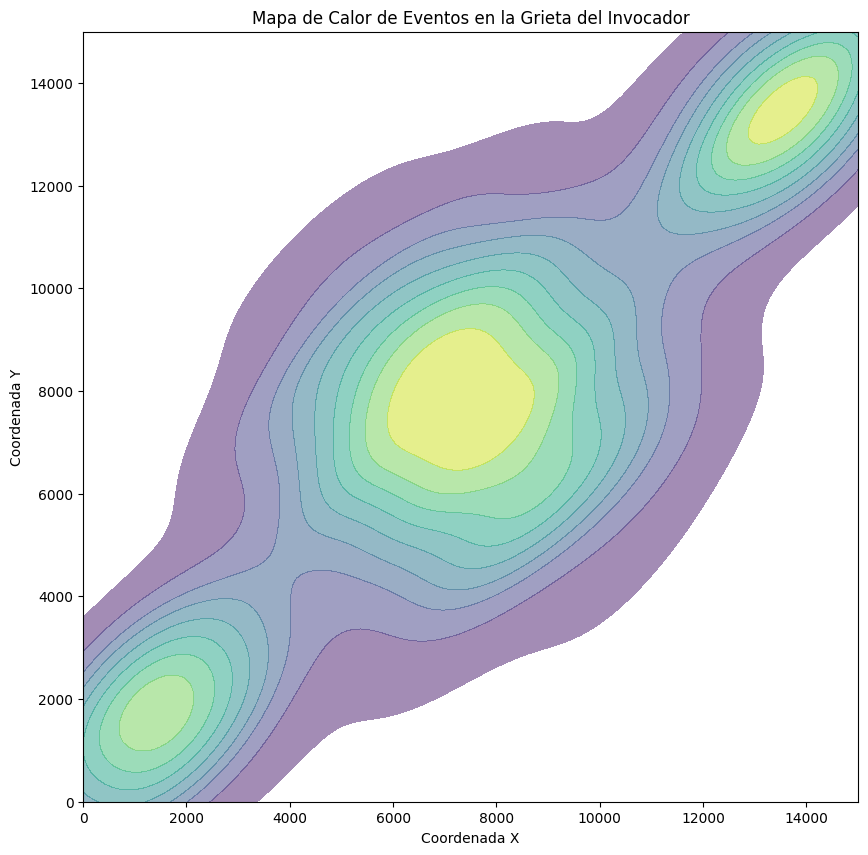

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import AnnotationBbox, OffsetImage # Para posibles futuros usos de imágenes

# --- 1. Crear un DataFrame de ejemplo similar a tus datos ---
# Reemplaza esto con la carga de tu df_enzo real
# df_enzo = pd.read_csv('tu_archivo_de_datos.csv') # Ejemplo si tus datos están en un CSV

# Datos de ejemplo para x e y que se parecen a tu imagen
# Asumimos que x e y están en el rango de coordenadas de LoL (0 a ~15000)
np.random.seed(42)
num_events = 1000 # Un número mayor de eventos para una mejor visualización KDE

# Generar puntos que tienden a estar más concentrados en ciertas áreas comunes de LoL
# Por ejemplo, alrededor de las bases y el centro del mapa
x_coords = np.concatenate([
    np.random.normal(1500, 1000, int(num_events*0.2)),  # Base azul
    np.random.normal(13500, 1000, int(num_events*0.2)), # Base roja
    np.random.normal(7500, 2000, int(num_events*0.6))    # Centro del mapa
])
y_coords = np.concatenate([
    np.random.normal(1500, 1000, int(num_events*0.2)),  # Base azul
    np.random.normal(13500, 1000, int(num_events*0.2)), # Base roja
    np.random.normal(7500, 2000, int(num_events*0.6))    # Centro del mapa
])

# Asegurarse de que las coordenadas estén dentro de los límites del mapa (ej. 0 a 15000)
x_coords = np.clip(x_coords, 0, 15000)
y_coords = np.clip(y_coords, 0, 15000)

df_eventos_lol = pd.DataFrame({
    'timestamp_ms': np.arange(num_events) * 60000, # Ejemplo de timestamp
    'x': x_coords,
    'y': y_coords
})

print("DataFrame de eventos de ejemplo creado:")
print(df_eventos_lol.head())


# --- 2. Cargar la imagen del mapa de LoL ---
# RUTA A TU IMAGEN DEL MAPA DE LOL
# ¡IMPORTANTE!: Reemplaza 'path/to/your/lol_map.png' con la ruta real de tu imagen.
# Descarga una imagen del mapa de la Grieta del Invocador (Summoner's Rift)
# Por ejemplo: 'summoners_rift_map.png' o 'lol_map_clean.jpg'
try:
    mapa_lol_img = plt.imread('/content/mapa_LoL.png') # <--- ¡CAMBIA ESTA RUTA!
except FileNotFoundError:
    print("\nERROR: No se encontró la imagen del mapa.")
    print("Por favor, descarga una imagen del mapa de la Grieta del Invocador y")
    print("colócala en la misma carpeta que tu script, o especifica la ruta completa.")
    print("Por ejemplo, busca 'Summoner's Rift map clean' en Google Images.")
    # Si no tienes la imagen, puedes salir o usar un plot vacío para ver el KDE sin fondo.
    exit() # Sale del script si no encuentra la imagen

# --- 3. Configuración del gráfico ---
fig, ax = plt.subplots(figsize=(10, 10)) # Un tamaño cuadrado suele ser mejor para mapas

# Dibuja la imagen del mapa como fondo
# extent=[x_min, x_max, y_min, y_max] define las coordenadas que corresponden a los bordes de la imagen
# Las coordenadas de LoL van de 0 a aproximadamente 14870 o 15000.
# Ajusta 'extent' si tu mapa de LoL tiene diferentes límites o si tus coordenadas no son de 0 a 15000.
map_x_min, map_x_max = 0, 15000
map_y_min, map_y_max = 0, 15000

# Dibuja el KDE
# Usa df_eventos_lol['x'] y df_eventos_lol['y'] para tus datos
sns.kdeplot(
    x=df_eventos_lol['x'],
    y=df_eventos_lol['y'],
    ax=ax,
    levels=10,        # Menos niveles para una visualización más suave o más niveles para detalle
    fill=True,        # Rellena el área entre los contornos (equivalente a 'shade=True')
    cmap='viridis',   # Mapa de colores (puedes probar 'hot', 'Reds', 'Blues', etc.)
    alpha=0.5,        # Transparencia del mapa de calor para que el mapa de fondo sea visible
    zorder=1,         # Dibuja el KDE encima del mapa (zorder del mapa es 0)
    thresh=0.05       # Umbral para no dibujar contornos muy bajos (opcional)
)

# Configuración de los ejes y título
ax.set_xlim(map_x_min, map_x_max)
ax.set_ylim(map_y_min, map_y_max)
ax.set_title('Mapa de Calor de Eventos en la Grieta del Invocador')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

# Opcional: Para ocultar las etiquetas de los ejes si solo quieres ver el mapa de calor
# ax.set_xticks([])
# ax.set_yticks([])

plt.show()

/tmp/ipython-input-3640845934.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, s=50, alpha=0.6, cmap='viridis') # 's' es el tamaño del marcador, 'alpha' es la transparencia


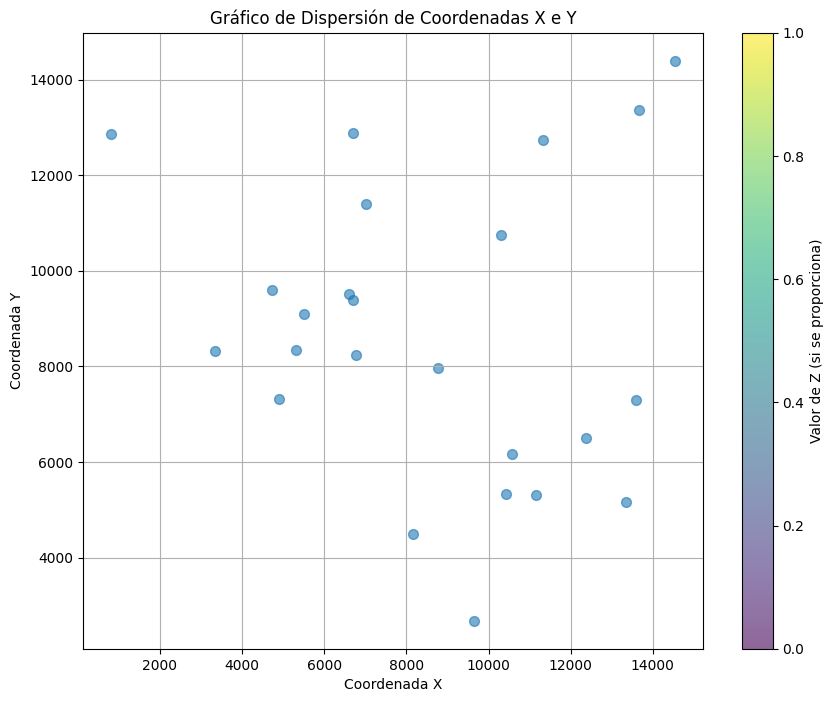

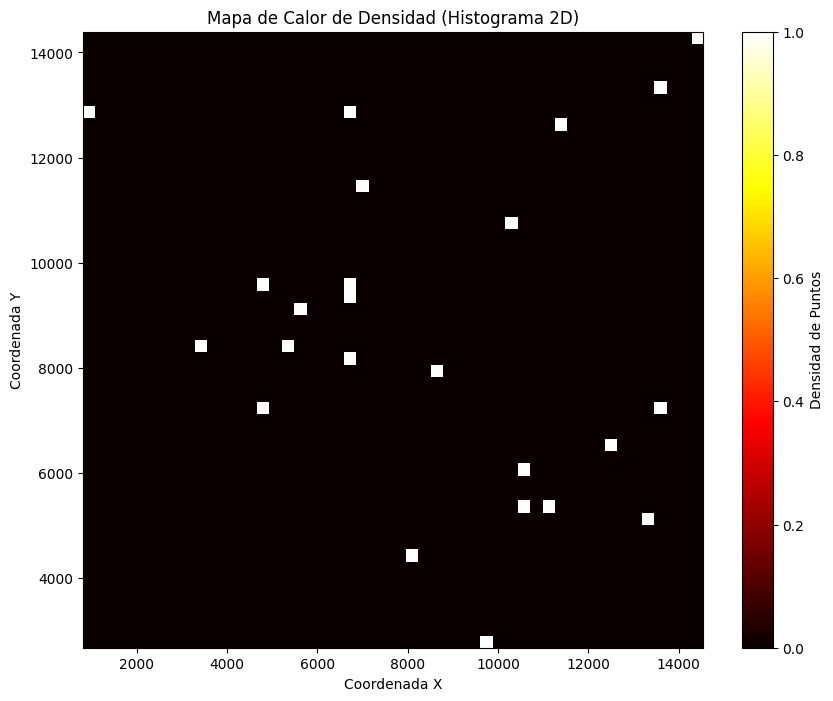

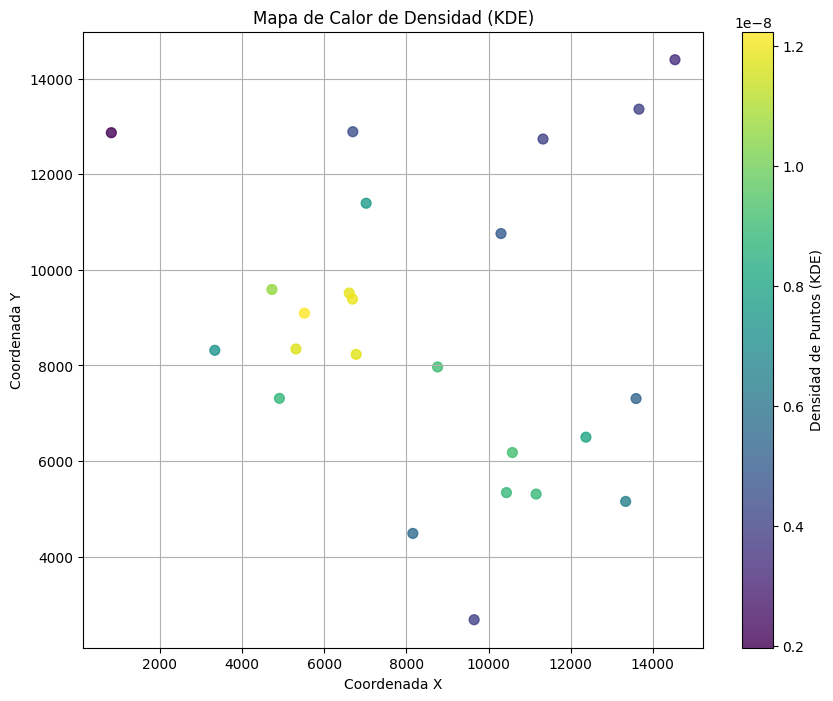

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Reemplaza estos datos con tus coordenadas 'x' y 'y' de la imagen ---
# Ejemplo de datos (reemplaza con los valores de la imagen)
# Puedes copiar y pegar las columnas 'x' e 'y' de la tabla de la imagen aquí
x = np.array([14539, 8760, 12371, 6690, 13663, 11327, 3338, 10304, 11160, 5313, 4729, 819, 6779, 13592, 9650, 8158, 4910, 6609, 6697, 7022, 10436, 10581, 5519, 13338])
y = np.array([14394, 7968, 6499, 9388, 13360, 12735, 8316, 10758, 5309, 8344, 9588, 12868, 8231, 7307, 2681, 4486, 7311, 9514, 12888, 11392, 5340, 6178, 9093, 5155])

# --- Creación del mapa de calor con scatter plot ---

# 1. Gráfico de dispersión básico
plt.figure(figsize=(10, 8))
plt.scatter(x, y, s=50, alpha=0.6, cmap='viridis') # 's' es el tamaño del marcador, 'alpha' es la transparencia

plt.title('Gráfico de Dispersión de Coordenadas X e Y')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.colorbar(label='Valor de Z (si se proporciona)') # Si no tienes un valor Z, esta barra no será muy útil
plt.show()

# 2. Mapa de calor usando un histograma 2D (más parecido a un mapa de calor de densidad)
# Esto te permite ver las regiones donde hay mayor concentración de puntos.
plt.figure(figsize=(10, 8))
hist, xedges, yedges = np.histogram2d(x, y, bins=50) # 'bins' controla la granularidad del mapa de calor
plt.imshow(hist.T, origin='lower', extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()], cmap='hot', aspect='auto')
plt.colorbar(label='Densidad de Puntos')
plt.title('Mapa de Calor de Densidad (Histograma 2D)')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.show()

# 3. Mapa de calor usando Kernel Density Estimation (KDE) para una suavidad mayor
# Esto proporciona una estimación más suave de la densidad de puntos.
try:
    from scipy.stats import gaussian_kde
    # Combina x e y en un array de 2D
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Ordena los puntos por la densidad para que los puntos más densos se dibujen encima
    idx = z.argsort()
    x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

    plt.figure(figsize=(10, 8))
    plt.scatter(x_kde, y_kde, c=z_kde, s=50, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Densidad de Puntos (KDE)')
    plt.title('Mapa de Calor de Densidad (KDE)')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True)
    plt.show()

except ImportError:
    print("La librería SciPy no está instalada. No se puede generar el mapa de calor con KDE.")
    print("Puedes instalarla con: pip install scipy")

#Mapa de calor del movimiento del jugador

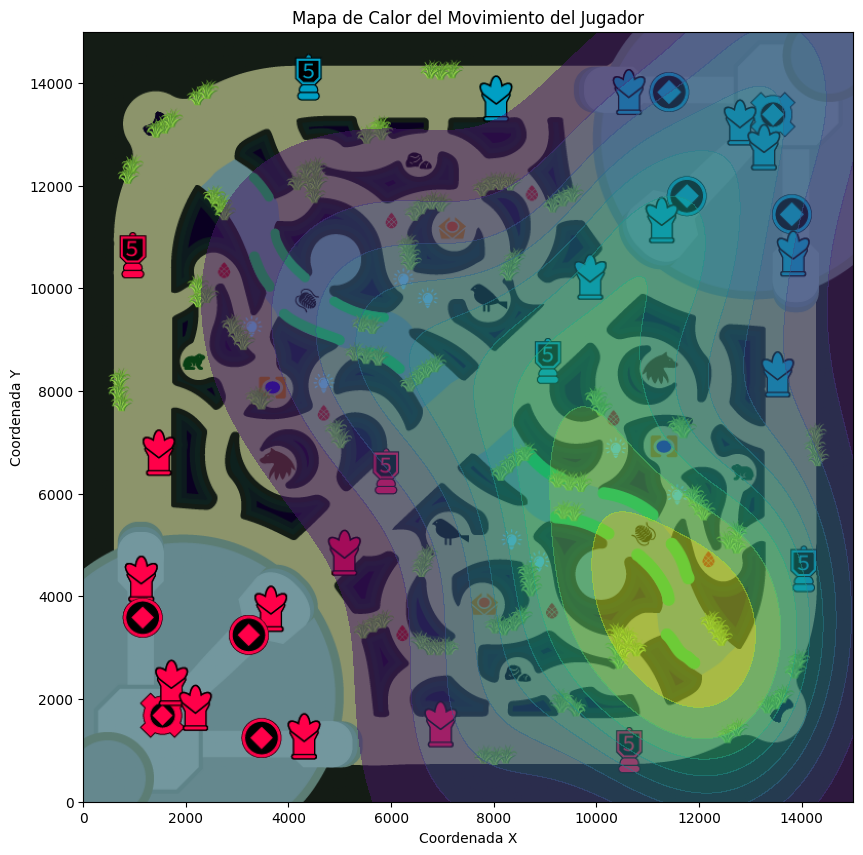

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


# --- Cargar la imagen del mapa ---
try:
    mapa_lol_img = plt.imread('/content/drive/MyDrive/8vo Semestre/Fundamentos ciencia de datos/Datos LOL/mapa_LoL.png')# <-- Verificar de tener esta imagen
except FileNotFoundError:
    print("ERROR: No se encontró la imagen del mapa.")
    exit()

# --- Crear el gráfico ---
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el mapa de fondo
ax.imshow(mapa_lol_img, extent=[0, 15000, 0, 15000], zorder=0)

# Dibujar el heatmap (KDE plot)
sns.kdeplot(
    x=df_pos['x'],
    y=df_pos['y'],
    ax=ax,
    levels=10,
    fill=True,
    cmap='viridis',
    alpha=0.5,
    zorder=1,
    thresh=0.05
)

# Configuración visual
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
ax.set_title('Mapa de Calor del Movimiento del Jugador')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')

plt.show()


#Vision por minuto

El Vision Score es una métrica que Riot diseñó para resumir el impacto de la visión de un jugador en una partida.

No es solo “wards puestos”, sino una combinación de varias acciones que contribuyen a la visión.
* Colocar wards (y que estén activos un tiempo razonable).

* Destruir wards enemigos.

* Revelar enemigos con habilidades, control de visión.

* Asistir en kills poco después de que un ward colocó visión del enemigo.

* El puntaje escala con la duración del ward, la importancia de la visión creada y la oportunidad estratégica.

Basicamente, es cuánto impacta la visión de un jugador en el control del mapa durante toda la partida.

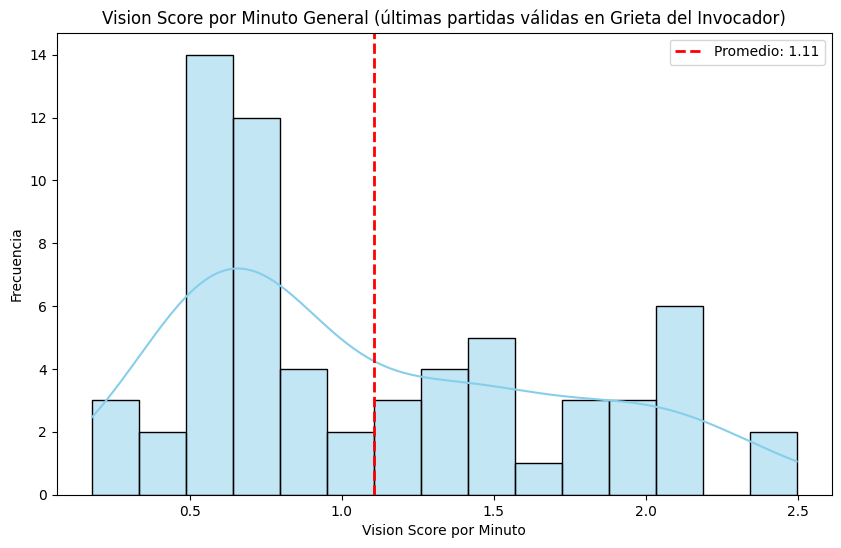

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Verificar que la columna existe ---
if "vision_score_per_min" not in df.columns:
    df["vision_score_per_min"] = df["vision_score"] / df["game_duration"].replace(0, 1)

# --- Filtrar solo partidas con VS/min > 0 (ignora ARAM, CHERRY, etc.) ---
df_filtered = df[df["vision_score_per_min"] > 0]

# --- Calcular promedio solo con partidas válidas ---
avg_vs_min = df_filtered["vision_score_per_min"].mean()

# --- Graficar histograma ---
plt.figure(figsize=(10,6))
sns.histplot(df_filtered["vision_score_per_min"], bins=15, kde=True, color="skyblue")

# Línea del promedio
plt.axvline(avg_vs_min, color="red", linestyle="--", linewidth=2, label=f"Promedio: {avg_vs_min:.2f}")

# Rango recomendado (1.5–2)
#plt.axvspan(1.5, 2.0, color="green", alpha=0.2, label="Rango recomendado (Soportes)")

plt.title("Vision Score por Minuto General (últimas partidas válidas en Grieta del Invocador)")
plt.xlabel("Vision Score por Minuto")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


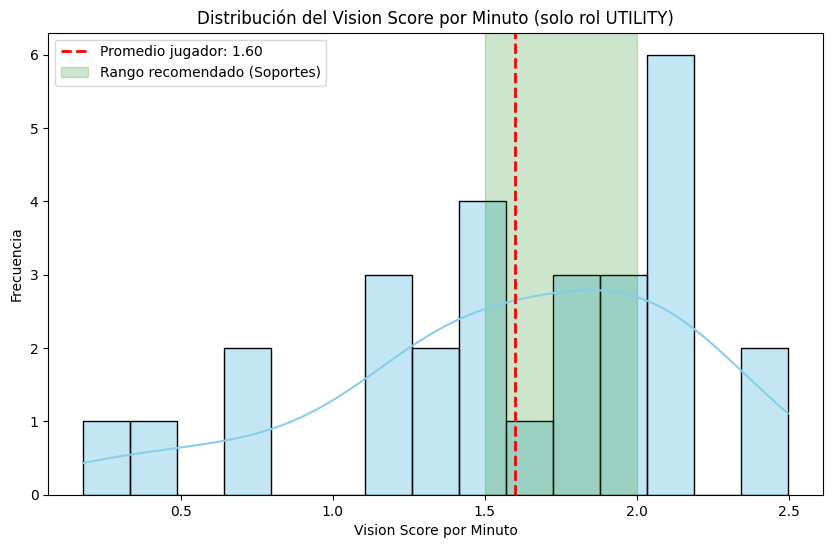

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Asegurarnos de que existe la métrica ---
if "vision_score_per_min" not in df.columns:
    df["vision_score_per_min"] = df["vision_score"] / df["game_duration"].replace(0, 1)

# --- Filtrar solo partidas de rol "UTILITY" ---
df_supports = df[df["team_position"] == "UTILITY"].copy()

# --- Ignorar partidas sin visión válida ---
df_supports = df_supports[df_supports["vision_score_per_min"] > 0]

# --- Calcular promedio ---
avg_vs_min = df_supports["vision_score_per_min"].mean()

# --- Graficar histograma ---
plt.figure(figsize=(10,6))
sns.histplot(df_supports["vision_score_per_min"], bins=15, kde=True, color="skyblue")

# Línea del promedio del jugador
plt.axvline(avg_vs_min, color="red", linestyle="--", linewidth=2, label=f"Promedio jugador: {avg_vs_min:.2f}")

# Rango recomendado (1.5–2.5)
plt.axvspan(1.5, 2, color="green", alpha=0.2, label="Rango recomendado (Soportes)")

plt.title("Distribución del Vision Score por Minuto (solo rol UTILITY)")
plt.xlabel("Vision Score por Minuto")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()



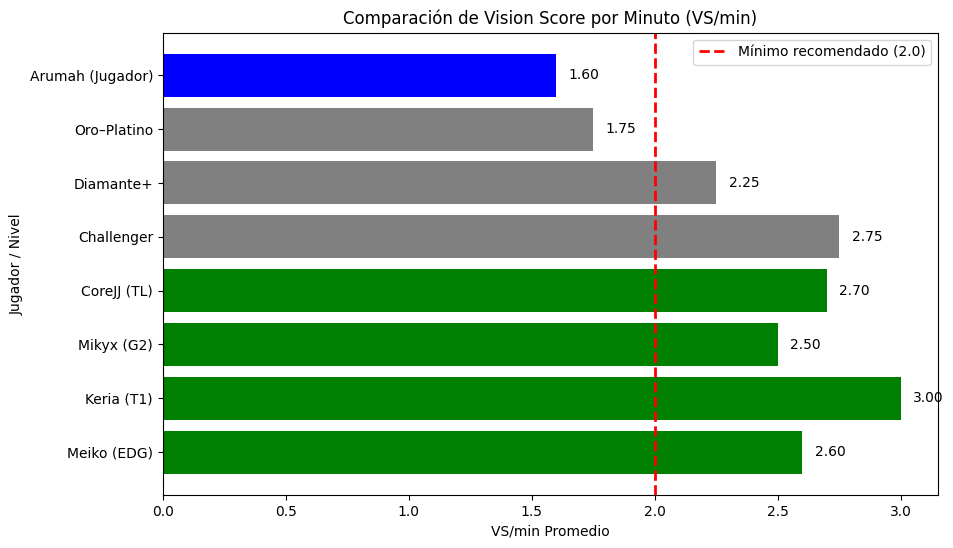

In [15]:
import matplotlib.pyplot as plt

# --- Datos ---
players = [
    "Arumah (Jugador)",
    "Oro–Platino",
    "Diamante+",
    "Challenger",
    "CoreJJ (TL)",
    "Mikyx (G2)",
    "Keria (T1)",
    "Meiko (EDG)"
]

vs_min = [
    avg_vs_min,   # Arumah
    1.75,   # Promedio Oro–Platino
    2.25,   # Promedio Diamante+
    2.75,   # Promedio Challenger
    2.7,    # CoreJJ
    2.5,    # Mikyx
    3.0,    # Keria
    2.6     # Meiko
]

# --- Colores por categoría ---
colors = [
    "blue",      # Arumah
    "gray",      # Oro–Platino
    "gray",      # Diamante+
    "gray",      # Challenger
    "green",     # CoreJJ
    "green",     # Mikyx
    "green",     # Keria
    "green"      # Meiko
]

# --- Crear gráfico ---
plt.figure(figsize=(10,6))
bars = plt.barh(players, vs_min, color=colors)

# Línea de referencia (ideal mínimo de soportes: 2.0)
plt.axvline(2.0, color="red", linestyle="--", linewidth=2, label="Mínimo recomendado (2.0)")

# Etiquetas de valores en las barras
for bar, value in zip(bars, vs_min):
    plt.text(value + 0.05, bar.get_y() + bar.get_height()/2,
             f"{value:.2f}", va='center')

plt.title("Comparación de Vision Score por Minuto (VS/min)")
plt.xlabel("VS/min Promedio")
plt.ylabel("Jugador / Nivel")
plt.legend()
plt.gca().invert_yaxis()  # Poner Arumah arriba
plt.show()


In [16]:
#--- Listas de campeones por tipo ---

#1. Enchanters (curar, escudar, potenciar)
#enchanters = ["Janna", "Lulu", "Soraka", "Nami", "Yuumi", "RenataGlasc", "Karma", "Zilean"]
enchanters = ["Janna", "Karma", "Lulu", "Milio", "Nami", "RenataGlasc", "Senna",  "Seraphine", "Sona", "Soraka", "Taric", "Yuumi"]

#2. Engage / Tank Supports (iniciadores, tanques)
engage_tanks = ["Leona", "Nautilus", "Alistar", "Rell", "Braum", "Thresh", "Rakan", "TahmKench", "Galio"]

#3. Poke / Mage Supports (daño y hostigamiento)
poke_mages = ["Zyra", "Brand", "Xerath", "Velkoz", "Lux", "Morgana", "Hwei"]

#4. Peel Supports (protección y desenganche)
peel_supports = ["TahmKench", "Braum", "Janna", "Zilean", "Morgana"]

#5. Catch Supports (cazar picks)
#catch_supports = ["Blitzcrank", "Thresh", "Pyke", "Rakan", "Shaco"]
catch_supports = ["Bard", "Blitzcrank", "Ivern", "Jhin", "Morgana", "Neeko", "Pyke", "Rakan", "Thresh", "Zyra"]

#6. Utility / Hybrid Supports (mezcla de roles)
#utility_hybrids = ["Morgana", "Karma", "Senna", "Swain", "Zilean"]

⚠️ No hay partidas para Soportes Enchanter


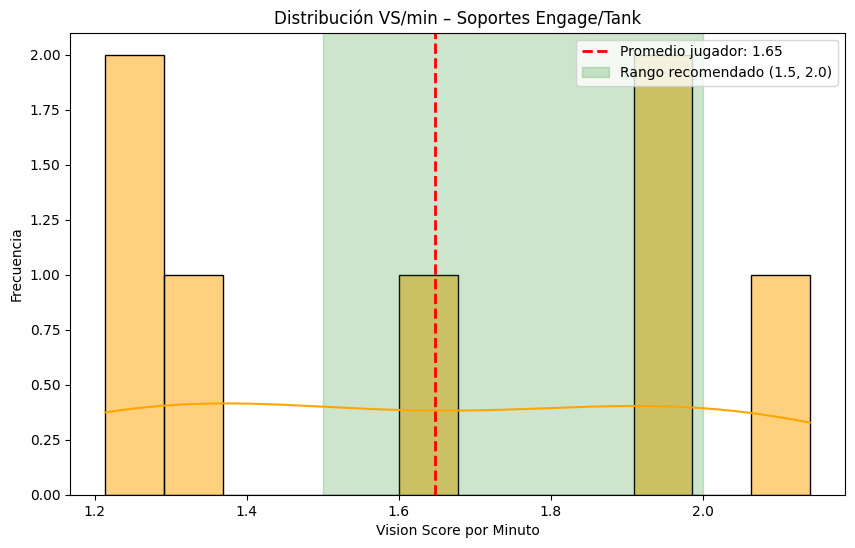

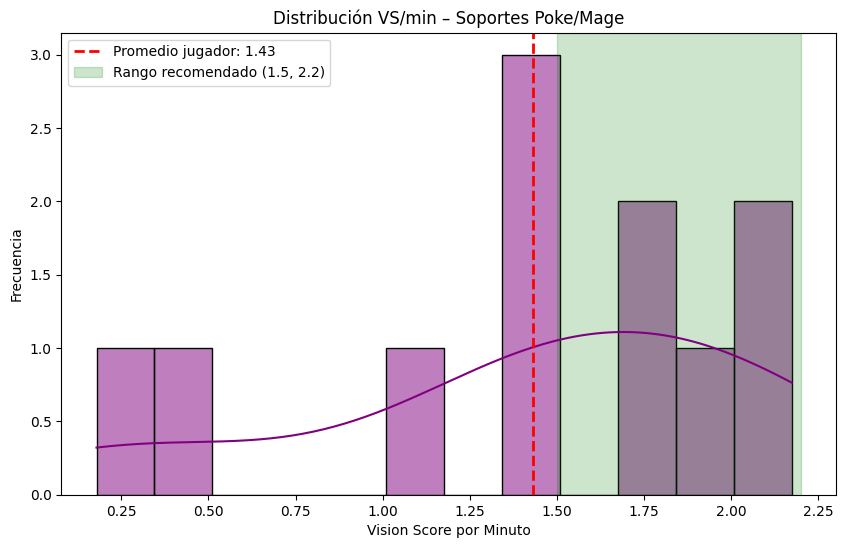

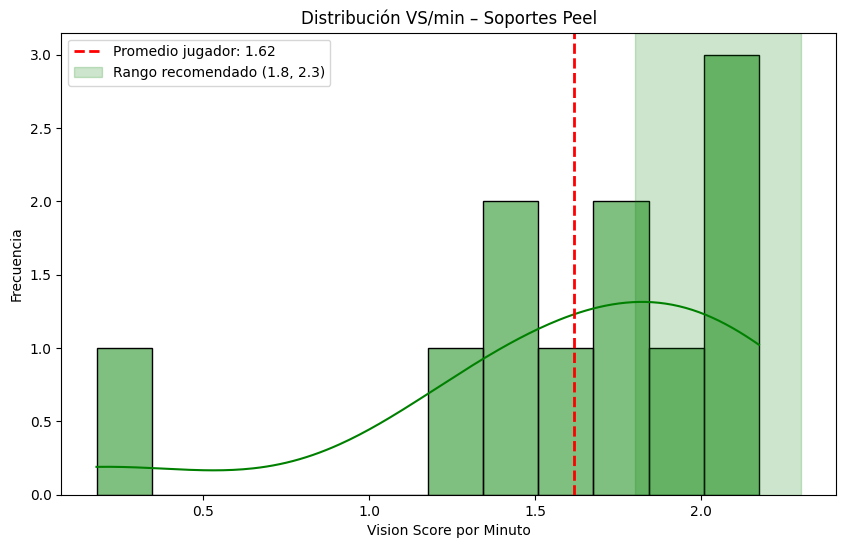

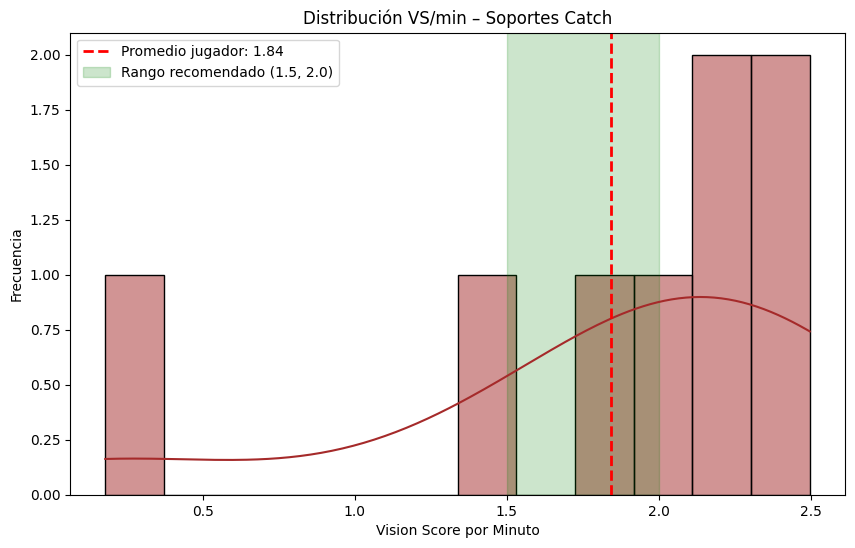

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filtrar solo rol soporte con VS/min válido ---
df_support = df[(df["team_position"] == "UTILITY") & (df["vision_score_per_min"] > 0)].copy()

# --- Función para graficar por tipo ---
def plot_support_hist(df_support, champions, rango, color, titulo):
    df_filtered = df_support[df_support["champion"].isin(champions)]
    if df_filtered.empty:
        print(f"⚠️ No hay partidas para {titulo}")
        return
    avg_value = df_filtered["vision_score_per_min"].mean()

    plt.figure(figsize=(10,6))
    sns.histplot(df_filtered["vision_score_per_min"], bins=12, kde=True, color=color)
    plt.axvline(avg_value, color="red", linestyle="--", linewidth=2, label=f"Promedio jugador: {avg_value:.2f}")
    plt.axvspan(rango[0], rango[1], color="green", alpha=0.2, label=f"Rango recomendado {rango}")
    plt.title(f"Distribución VS/min – {titulo}")
    plt.xlabel("Vision Score por Minuto")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

# --- Graficar por cada tipo ---
plot_support_hist(df_support, enchanters, (2.0, 2.5), "skyblue", "Soportes Enchanter")
plot_support_hist(df_support, engage_tanks, (1.5, 2.0), "orange", "Soportes Engage/Tank")
plot_support_hist(df_support, poke_mages, (1.5, 2.2), "purple", "Soportes Poke/Mage")
plot_support_hist(df_support, peel_supports, (1.8, 2.3), "green", "Soportes Peel")
plot_support_hist(df_support, catch_supports, (1.5, 2.0), "brown", "Soportes Catch")
#plot_support_hist(df_support, utility_hybrids, (1.8, 2.2), "gray", "Soportes Utility/Hybrid")


#Medidas tendencia central Puntos de Vision por minuto

In [23]:
# Tendencia central
media = df['vision_score_per_min'].mean()
mediana = df['vision_score_per_min'].median()
moda = df['vision_score_per_min'].mode()[0]  # puede haber más de una moda

# Medidas de dispersión
varianza = df['vision_score_per_min'].var()
desviacion = df['vision_score_per_min'].std()
rango = df['vision_score_per_min'].max() - df['vision_score_per_min'].min()
q1 = df['vision_score_per_min'].quantile(0.25)
q3 = df['vision_score_per_min'].quantile(0.75)
iqr = q3 - q1

print("Medidas de tendencia central:")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")

print("\nMedidas de dispersión:")
print(f"Varianza: {varianza}")
print(f"Desviación estándar: {desviacion}")
print(f"Rango: {rango}")
print(f"Q1 (25%): {q1}")
print(f"Q3 (75%): {q3}")
print(f"Rango intercuartílico (IQR): {iqr}")


Medidas de tendencia central:
Media: 0.7077321359120521
Mediana: 0.5894462522428527
Moda: 0.0

Medidas de dispersión:
Varianza: 0.5239987980260098
Desviación estándar: 0.7238776126017503
Rango: 2.4971878515185604
Q1 (25%): 0.0
Q3 (75%): 1.2244270767905532
Rango intercuartílico (IQR): 1.2244270767905532


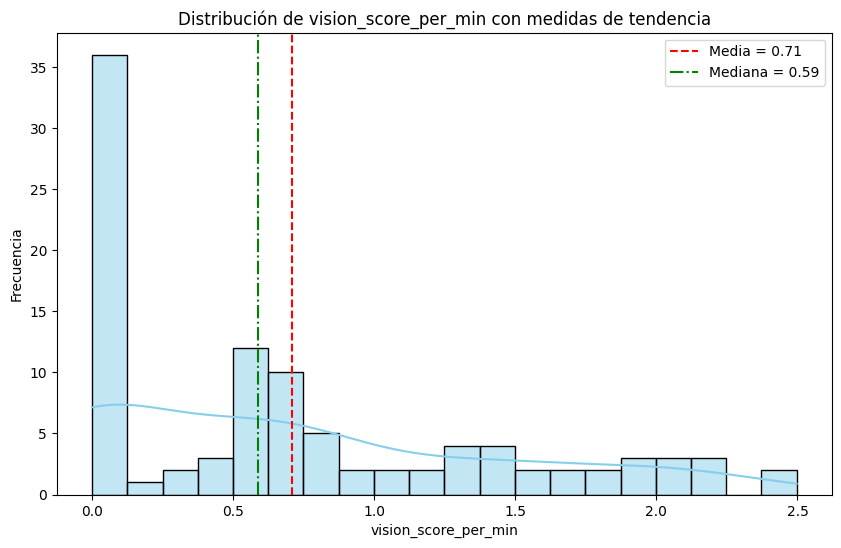

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


col = "vision_score_per_min"

plt.figure(figsize=(10,6))
sns.histplot(df[col], bins=20, kde=True, color="skyblue")

# Medidas
mean_val = df[col].mean()
median_val = df[col].median()
std_val = df[col].std()

# Líneas de referencia
plt.axvline(mean_val, color="red", linestyle="--", label=f"Media = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-.", label=f"Mediana = {median_val:.2f}")

plt.title(f"Distribución de {col} con medidas de tendencia")
plt.xlabel(col)
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


#VS/min por fase de partida

##Partida Individual

Analizando partida: LA1_1651924475
Participant ID: 5
VS total: 66
Duración: 31 minutos
Número de frames: 33
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 1
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 1
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 2
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 2
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 3
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 3
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 3
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 4
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 4
Evento ward encontrado: WARD_KILL, Participant: None, Minuto: 4
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 4
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 5
Evento ward encontrado: WARD_PLACED, Participant: None, Minuto: 5
Evento ward encontrado: WARD_PLACED,

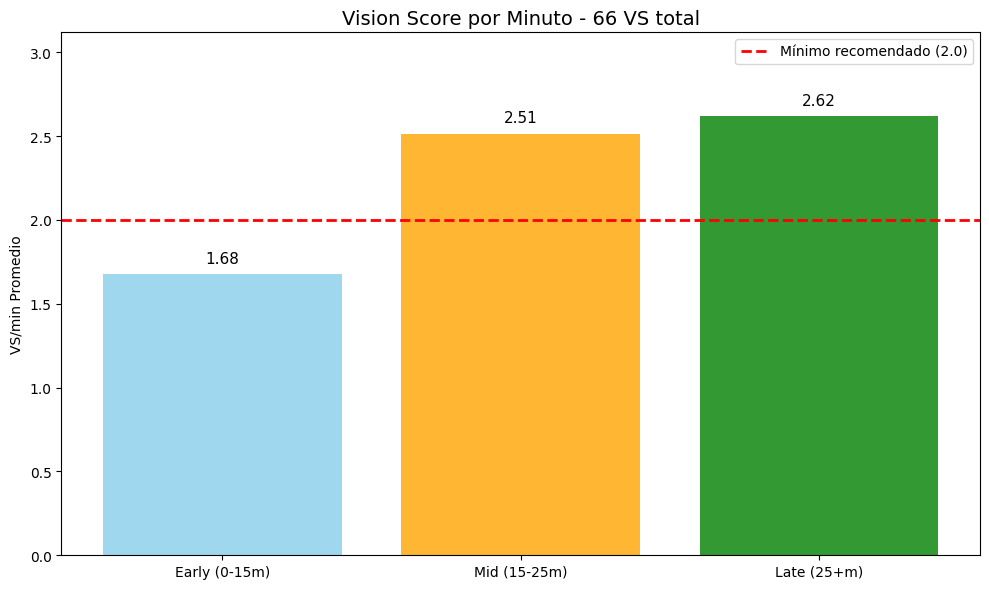

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-6430e375-f103-4aad-8ffa-aa00706b3e16"
HEADERS = {"X-Riot-Token": API_KEY}

def get_vs_by_phase_events(match_id, puuid):
    try:
        print(f"Analizando partida: {match_id}")

        # --- Obtener detalles de la partida ---
        match_info = requests.get(
            f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
            headers=HEADERS
        ).json()

        timeline = requests.get(
            f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline",
            headers=HEADERS
        ).json()

        # --- Buscar participantId del jugador ---
        participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
        participant_id = participant["participantId"]
        total_vs = participant["visionScore"]
        duration = match_info["info"]["gameDuration"] // 60  # minutos

        print(f"Participant ID: {participant_id}")
        print(f"VS total: {total_vs}")
        print(f"Duración: {duration} minutos")

        # --- DEBUG: Ver estructura del timeline ---
        print(f"Número de frames: {len(timeline['info']['frames'])}")

        # Contar todos los eventos para debug
        all_events = 0
        ward_events = 0

        early_wards_placed = 0
        mid_wards_placed = 0
        late_wards_placed = 0
        early_wards_killed = 0
        mid_wards_killed = 0
        late_wards_killed = 0

        for frame_idx, frame in enumerate(timeline["info"]["frames"]):
            minute = frame["timestamp"] // 60000
            events = frame.get("events", [])
            all_events += len(events)

            for event in events:
                event_type = event.get("type")
                event_participant = event.get("participantId")

                # Debug: mostrar eventos de wards
                if event_type in ["WARD_PLACED", "WARD_KILL"]:
                    ward_events += 1
                    print(f"Evento ward encontrado: {event_type}, Participant: {event_participant}, Minuto: {minute}")

                if event_participant == participant_id and event_type in ["WARD_PLACED", "WARD_KILL"]:
                    if event_type == "WARD_PLACED":
                        if minute <= 14:
                            early_wards_placed += 1
                        elif minute <= 25:
                            mid_wards_placed += 1
                        else:
                            late_wards_placed += 1
                    elif event_type == "WARD_KILL":
                        if minute <= 14:
                            early_wards_killed += 1
                        elif minute <= 25:
                            mid_wards_killed += 1
                        else:
                            late_wards_killed += 1

        print(f"Total eventos: {all_events}")
        print(f"Total eventos de wards: {ward_events}")
        print(f"Wards colocadas - Early: {early_wards_placed}, Mid: {mid_wards_placed}, Late: {late_wards_placed}")
        print(f"Wards eliminadas - Early: {early_wards_killed}, Mid: {mid_wards_killed}, Late: {late_wards_killed}")

        # --- Si no hay eventos, usar datos del match info ---
        total_wards_placed = participant["wardsPlaced"]
        total_wards_killed = participant["wardsKilled"]

        print(f"Del match info - Wards colocadas: {total_wards_placed}")
        print(f"Del match info - Wards eliminadas: {total_wards_killed}")

        # Si no encontramos eventos en el timeline, usar datos aproximados del match info
        if early_wards_placed + mid_wards_placed + late_wards_placed == 0:
            print("⚠️ No se encontraron eventos de wards en el timeline, usando aproximación...")

            # Distribuir proporcionalmente según la duración
            if duration <= 15:
                early_wards_placed = total_wards_placed
                early_wards_killed = total_wards_killed
            elif duration <= 25:
                early_wards_placed = int(total_wards_placed * 0.6)
                mid_wards_placed = total_wards_placed - early_wards_placed
                early_wards_killed = int(total_wards_killed * 0.6)
                mid_wards_killed = total_wards_killed - early_wards_killed
            else:
                early_wards_placed = int(total_wards_placed * 0.4)
                mid_wards_placed = int(total_wards_placed * 0.4)
                late_wards_placed = total_wards_placed - early_wards_placed - mid_wards_placed
                early_wards_killed = int(total_wards_killed * 0.4)
                mid_wards_killed = int(total_wards_killed * 0.4)
                late_wards_killed = total_wards_killed - early_wards_killed - mid_wards_killed

        # --- Calcular VS aproximado ---
        early_vs = (early_wards_placed * 1.0) + (early_wards_killed * 1.5)
        mid_vs = (mid_wards_placed * 1.0) + (mid_wards_killed * 1.5)
        late_vs = (late_wards_placed * 1.0) + (late_wards_killed * 1.5)

        total_estimated_vs = early_vs + mid_vs + late_vs

        # Ajustar al VS total real
        if total_estimated_vs > 0:
            scale_factor = total_vs / total_estimated_vs
            early_vs *= scale_factor
            mid_vs *= scale_factor
            late_vs *= scale_factor
        else:
            # Si no hay eventos, distribuir proporcionalmente
            if duration <= 15:
                early_vs = total_vs
            elif duration <= 25:
                early_vs = total_vs * 0.6
                mid_vs = total_vs * 0.4
            else:
                early_vs = total_vs * 0.3
                mid_vs = total_vs * 0.3
                late_vs = total_vs * 0.4

        # --- Calcular VS por minuto ---
        early_duration = min(15, duration)
        mid_duration = max(0, min(10, duration - 15))
        late_duration = max(0, duration - 25)

        summary = {
            "early_vs_min": early_vs / max(1, early_duration),
            "mid_vs_min": mid_vs / max(1, mid_duration),
            "late_vs_min": late_vs / max(1, late_duration),
            "game_duration_mins": duration,
            "total_vs": total_vs,
            "wards_placed": {
                "early": early_wards_placed,
                "mid": mid_wards_placed,
                "late": late_wards_placed
            },
            "wards_killed": {
                "early": early_wards_killed,
                "mid": mid_wards_killed,
                "late": late_wards_killed
            }
        }
        return summary

    except Exception as e:
        print(f"Error procesando partida {match_id}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# --- EJECUCIÓN ---
match_id = "LA1_1651924475"
puuid = "PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ"

vs_summary = get_vs_by_phase_events(match_id, puuid)

if vs_summary:
    print("\n" + "="*50)
    print("RESUMEN FINAL:")
    print("="*50)
    print(f"Early VS/min: {vs_summary['early_vs_min']:.2f}")
    print(f"Mid VS/min: {vs_summary['mid_vs_min']:.2f}")
    print(f"Late VS/min: {vs_summary['late_vs_min']:.2f}")
    print(f"Duración: {vs_summary['game_duration_mins']} minutos")
    print(f"VS total: {vs_summary['total_vs']}")
    print(f"Wards colocadas - Early: {vs_summary['wards_placed']['early']}, Mid: {vs_summary['wards_placed']['mid']}, Late: {vs_summary['wards_placed']['late']}")
    print(f"Wards eliminadas - Early: {vs_summary['wards_killed']['early']}, Mid: {vs_summary['wards_killed']['mid']}, Late: {vs_summary['wards_killed']['late']}")

    # --- GRAFICAR ---
    fases = ["Early (0-15m)", "Mid (15-25m)", "Late (25+m)"]
    valores = [
        vs_summary["early_vs_min"],
        vs_summary["mid_vs_min"],
        vs_summary["late_vs_min"]
    ]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(fases, valores, color=["skyblue", "orange", "green"], alpha=0.8)

    for bar, val in zip(bars, valores):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.05, f"{val:.2f}",
                 ha='center', va='bottom', fontsize=11)

    plt.title(f"Vision Score por Minuto - {vs_summary['total_vs']} VS total", fontsize=14)
    plt.ylabel("VS/min Promedio")
    plt.ylim(0, max(valores) + 0.5 if max(valores) > 0 else 2)
    plt.axhline(2.0, color="red", linestyle="--", linewidth=2, label="Mínimo recomendado (2.0)")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se pudo generar el análisis de VS por fases.")

##Ultimas 100 partidas

🚀 ANALIZADOR DE VISION SCORE - VERSIÓN OPTIMIZADA
📊 Cargando datos existentes de: lol_data_Arumah.xlsx
✅ Datos cargados: 100 partidas encontradas
✅ PUUID encontrado: PpDPLDsNjJy2H_hEnquPP9Q_3iknFPsl0Pxl3ZPeSD_d4HXpPEkzkatUc1G-M5481NCPaRKF3R-ABQ

🔧 CONFIGURACIÓN DE FILTROS
📊 Información de tus datos:
   🗺️  Grieta del Invocador (VS>0): 64 partidas
   ⚠️  Mapas especiales/VS=0: 36 partidas
      - ARAM (Mapa 12): 33 partidas
      - CHERRY (Mapa 30): 2 partidas
      - CLASSIC (Grieta del Invocador): 1 partidas

   🎯 Posiciones jugadas:
      - UTILITY: 28 partidas
      - TOP: 17 partidas
      - JUNGLE: 6 partidas
      - MIDDLE: 5 partidas
      - BOTTOM: 1 partidas

1️⃣ FILTRO: Mapas especiales/Vision Score = 0
   ✅ Incluir todas las partidas (100 total)
   ❌ Solo Grieta del Invocador con VS>0 (64 partidas)

¿Incluir mapas especiales? (s/N) [por defecto: N]: N

2️⃣ FILTRO: Posiciones
   Posiciones disponibles:
   - UTILITY
   - TOP
   - JUNGLE
   - MIDDLE
   - BOTTOM

   Opciones:
  

Procesando: 100%|██████████| 28/28 [00:00<00:00, 6890.43it/s]

✅ Partidas analizadas: 28
❌ Partidas fallidas: 0

💾 Datos guardados en: vision_score_analysis_Arumah_SR_only_UTILITY.xlsx
📊 REPORTE RESUMEN - VISION SCORE POR FASES
🎮 Partidas analizadas: 28
⚠️  Partidas excluidas (VS=0): 72
📈 Total de partidas originales: 100
👁️ VS/min promedio - Early (0-15min): 1.19
👁️ VS/min promedio - Mid (15-25min): 2.08
👁️ VS/min promedio - Late (25+min): 2.66
🏆 VS total promedio: 47.39
🎯 Win Rate: 60.7%

--- 📈 Análisis de Rendimiento ---
Partidas con buen VS Early (≥2.0/min): 1/28 (3.6%)
Partidas con buen VS Mid (≥2.0/min): 13/28 (46.4%)
Partidas con buen VS Late (≥2.0/min): 13/28 (46.4%)

--- 🎲 Por Modo de Juego (Partidas Analizadas) ---
CLASSIC: 22 partidas, VS/min: 1.22/2.12/2.51
SWIFTPLAY: 6 partidas, VS/min: 1.08/1.94/3.20

--- 📋 Resumen General ---
✅ Partidas válidas analizadas: 28 (28.0%)
❌ Partidas excluidas: 72 (72.0%)

📊 Generando gráficos...



/tmp/ipython-input-3596660245.py:542: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3596660245.py:542: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3596660245.py:542: UserWarning: Glyph 127941 (\N{SPORTS MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3596660245.py:542: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.p

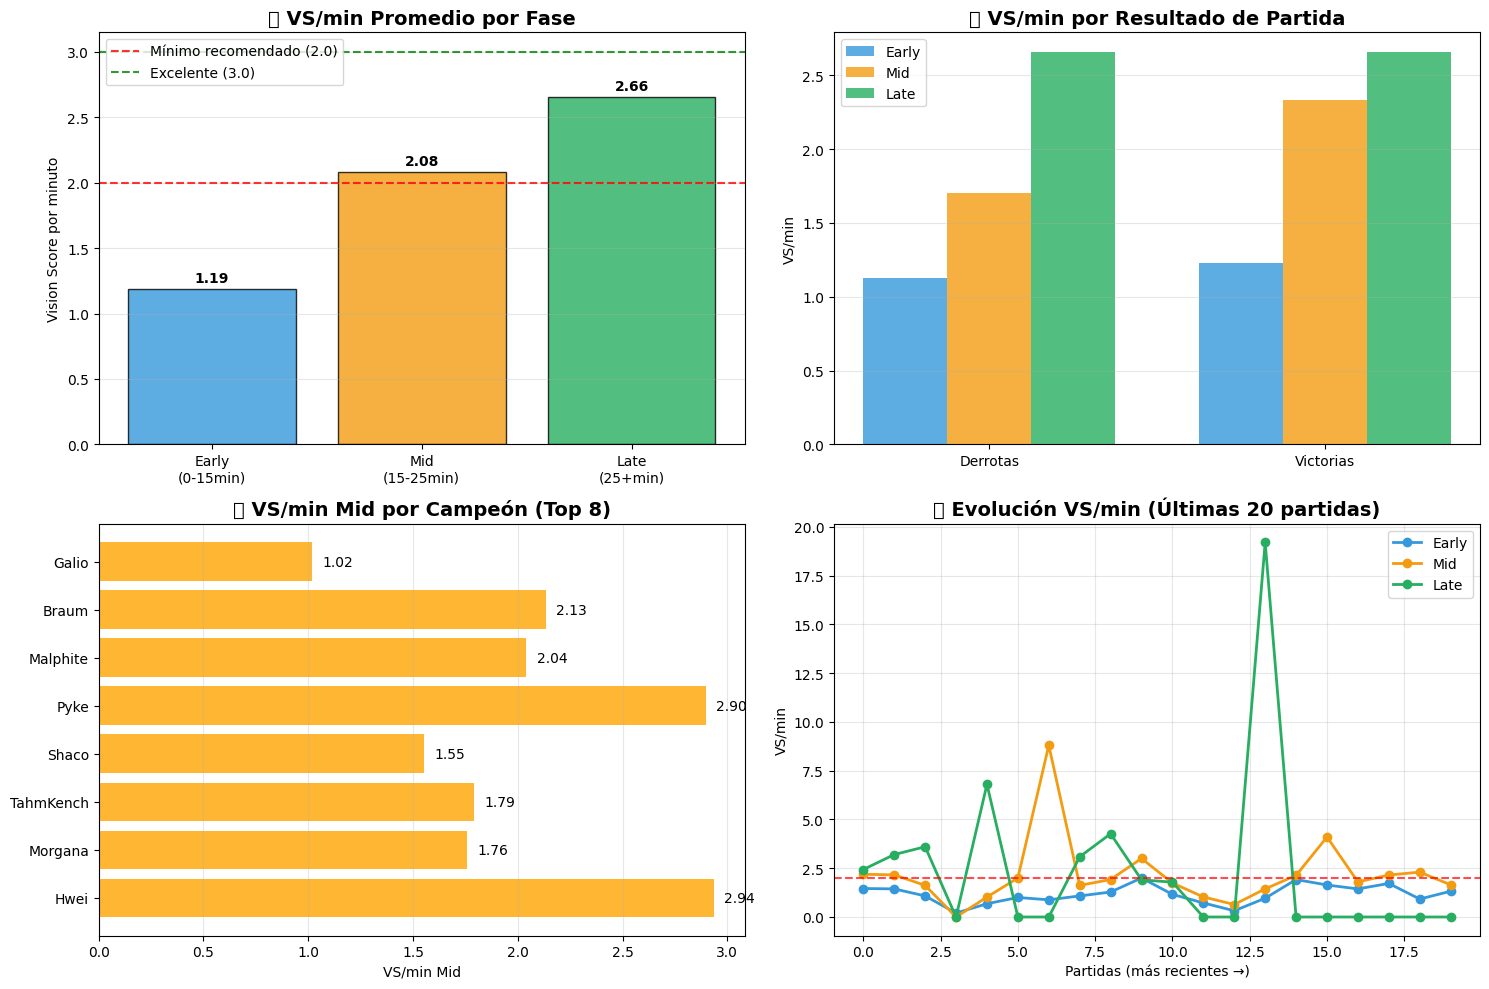

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Archivo descargado!

✨ ¡Análisis completado!
📈 Se analizaron 28 partidas filtradas de un total de 100
📋 Resumen: 72 partidas excluidas por filtros aplicados


In [39]:
def get_user_filters(existing_df):
    """Obtener filtros del usuario de manera interactiva"""
    print("\n🔧 CONFIGURACIÓN DE FILTROS")
    print("="*50)

    # Mostrar información sobre los datos disponibles
    print("📊 Información de tus datos:")

    # Análisis de mapas especiales
    special_maps = existing_df[(existing_df['vision_score'] == 0) | (existing_df['map_id'] != 11)]
    normal_maps = existing_df[(existing_df['vision_score'] > 0) & (existing_df['map_id'] == 11)]

    print(f"   🗺️  Grieta del Invocador (VS>0): {len(normal_maps)} partidas")
    if len(special_maps) > 0:
        print(f"   ⚠️  Mapas especiales/VS=0: {len(special_maps)} partidas")
        special_summary = special_maps.groupby(['game_mode', 'map_id']).size().reset_index(name='count')
        for _, row in special_summary.iterrows():
            map_name = "Grieta del Invocador" if row['map_id'] == 11 else f"Mapa {row['map_id']}"
            print(f"      - {row['game_mode']} ({map_name}): {row['count']} partidas")

    # Análisis de posiciones
    position_summary = existing_df.groupby('team_position').size().reset_index(name='count').sort_values('count', ascending=False)
    print(f"\n   🎯 Posiciones jugadas:")
    for _, row in position_summary.iterrows():
        if row['team_position'] and row['team_position'] != '':
            print(f"      - {row['team_position']}: {row['count']} partidas")

    # FILTRO 1: Mapas especiales
    print(f"\n1️⃣ FILTRO: Mapas especiales/Vision Score = 0")
    print(f"   ✅ Incluir todas las partidas ({len(existing_df)} total)")
    print(f"   ❌ Solo Grieta del Invocador con VS>0 ({len(normal_maps)} partidas)")

    try:
        include_special = input("\n¿Incluir mapas especiales? (s/N) [por defecto: N]: ").strip().lower()
        include_special_maps = include_special in ['s', 'si', 'sí', 'y', 'yes']
    except:
        include_special_maps = False

    # FILTRO 2: Posiciones
    print(f"\n2️⃣ FILTRO: Posiciones")
    print("   Posiciones disponibles:")
    available_positions = []
    for _, row in position_summary.iterrows():
        if row['team_position'] and row['team_position'] != '':
            available_positions.append(row['team_position'])
            print(f"   - {row['team_position']}")

    print("\n   Opciones:")
    print("   🔸 Presiona ENTER para incluir todas las posiciones")
    print("   🔸 Escribe las posiciones separadas por comas (ej: TOP,JUNGLE,MIDDLE)")

    try:
        position_input = input("\nSelecciona posiciones: ").strip()
        if position_input:
            selected_positions = [pos.strip().upper() for pos in position_input.split(',')]
            # Validar posiciones
            valid_positions = []
            for pos in selected_positions:
                if pos in available_positions:
                    valid_positions.append(pos)
                else:
                    print(f"⚠️  Posición '{pos}' no encontrada, será ignorada")
            selected_positions = valid_positions if valid_positions else None
        else:
            selected_positions = None
    except:
        selected_positions = None

    # Mostrar resumen de filtros seleccionados
    print(f"\n📋 RESUMEN DE FILTROS SELECCIONADOS:")
    print(f"   🗺️  Mapas especiales: {'Incluidos' if include_special_maps else 'Excluidos'}")
    if selected_positions:
        print(f"   🎯 Posiciones: {', '.join(selected_positions)}")
    else:
        print(f"   🎯 Posiciones: Todas incluidas")

    return include_special_maps, selected_positions

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
import os

# --- CONFIGURACIÓN ---
API_KEY = "RGAPI-6430e375-f103-4aad-8ffa-aa00706b3e16"
HEADERS = {"X-Riot-Token": API_KEY}
RIOT_ID = "Arumah"  # Usar el mismo que ya tienes
TAG_LINE = "Aruh"   # Usar el mismo que ya tienes

def load_existing_data(riot_id):
    """Cargar datos existentes si están disponibles"""
    filename = f"lol_data_{riot_id}.xlsx"
    if os.path.exists(filename):
        print(f"📊 Cargando datos existentes de: {filename}")
        df = pd.read_excel(filename)
        print(f"✅ Datos cargados: {len(df)} partidas encontradas")
        return df
    else:
        print(f"❌ No se encontró el archivo: {filename}")
        print("💡 Ejecuta primero el código de extracción de datos base")
        return None

def get_vs_by_phase_timeline(match_id, puuid, existing_match_data=None):
    """Analizar VS por fase usando timeline (optimizado)"""
    try:
        # Si ya tenemos datos básicos, usarlos
        if existing_match_data is not None:
            duration = existing_match_data['game_duration']
            total_vs = existing_match_data['vision_score']
            champion = existing_match_data['champion']
            win = existing_match_data['win']
            queue_id = existing_match_data['queue_id']
            game_mode = existing_match_data['game_mode']
            date = existing_match_data['date']
            total_wards_placed = existing_match_data.get('wards_placed', 0)
            total_wards_killed = existing_match_data.get('wards_destroyed', 0)
        else:
            # Fallback: obtener datos básicos de la API
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()

            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            duration = match_info["info"]["gameDuration"] // 60
            total_vs = participant["visionScore"]
            champion = participant["championName"]
            win = participant["win"]
            queue_id = match_info["info"]["queueId"]
            game_mode = match_info["info"]["gameMode"]
            date = datetime.fromtimestamp(match_info["info"]["gameCreation"] / 1000).strftime('%Y-%m-%d')
            total_wards_placed = participant["wardsPlaced"]
            total_wards_killed = participant["wardsKilled"]

        # --- Obtener timeline para análisis detallado ---
        timeline_response = requests.get(
            f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline",
            headers=HEADERS
        )

        if timeline_response.status_code != 200:
            # Si no hay timeline, usar estimación
            return estimate_vs_by_phase(match_id, duration, total_vs, champion, win,
                                      queue_id, game_mode, date, total_wards_placed, total_wards_killed)

        timeline = timeline_response.json()

        # --- Buscar participantId del jugador ---
        # Necesitamos obtener el participantId del timeline
        participant_id = None
        if existing_match_data is None:
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()
            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            participant_id = participant["participantId"]
        else:
            # Buscar en el timeline o hacer otra llamada mínima
            match_info = requests.get(
                f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}",
                headers=HEADERS
            ).json()
            participant = next(p for p in match_info["info"]["participants"] if p["puuid"] == puuid)
            participant_id = participant["participantId"]

        # --- Contar eventos de wards por fase ---
        early_wards_placed = mid_wards_placed = late_wards_placed = 0
        early_wards_killed = mid_wards_killed = late_wards_killed = 0

        for frame in timeline["info"]["frames"]:
            minute = frame["timestamp"] // 60000
            for event in frame.get("events", []):
                if event.get("participantId") == participant_id:
                    event_type = event.get("type")

                    if event_type == "WARD_PLACED":
                        if minute <= 14:
                            early_wards_placed += 1
                        elif minute <= 25:
                            mid_wards_placed += 1
                        else:
                            late_wards_placed += 1

                    elif event_type == "WARD_KILL":
                        if minute <= 14:
                            early_wards_killed += 1
                        elif minute <= 25:
                            mid_wards_killed += 1
                        else:
                            late_wards_killed += 1

        # --- Calcular VS por fase ---
        early_vs = (early_wards_placed * 1.0) + (early_wards_killed * 1.5)
        mid_vs = (mid_wards_placed * 1.0) + (mid_wards_killed * 1.5)
        late_vs = (late_wards_placed * 1.0) + (late_wards_killed * 1.5)

        total_estimated_vs = early_vs + mid_vs + late_vs

        # Ajustar al VS total real si es necesario
        if total_estimated_vs > 0 and abs(total_estimated_vs - total_vs) > total_vs * 0.1:
            scale_factor = total_vs / total_estimated_vs
            early_vs *= scale_factor
            mid_vs *= scale_factor
            late_vs *= scale_factor

        # --- Calcular VS por minuto ---
        early_duration = min(15, duration)
        mid_duration = max(0, min(10, duration - 15)) if duration > 15 else 0
        late_duration = max(0, duration - 25) if duration > 25 else 0

        return {
            "match_id": match_id,
            "champion": champion,
            "win": win,
            "game_duration": duration,
            "total_vs": total_vs,
            "early_vs_min": early_vs / max(1, early_duration),
            "mid_vs_min": mid_vs / max(1, mid_duration) if mid_duration > 0 else 0,
            "late_vs_min": late_vs / max(1, late_duration) if late_duration > 0 else 0,
            "early_wards_placed": early_wards_placed,
            "mid_wards_placed": mid_wards_placed,
            "late_wards_placed": late_wards_placed,
            "early_wards_killed": early_wards_killed,
            "mid_wards_killed": mid_wards_killed,
            "late_wards_killed": late_wards_killed,
            "queue_id": queue_id,
            "game_mode": game_mode,
            "date": date
        }

    except Exception as e:
        print(f"❌ Error procesando partida {match_id}: {e}")
        return None

def estimate_vs_by_phase(match_id, duration, total_vs, champion, win, queue_id, game_mode, date, wards_placed, wards_killed):
    """Estimar VS por fase cuando no hay timeline disponible"""

    # Estimación basada en duración de la partida
    if duration <= 15:
        early_vs = total_vs
        mid_vs = late_vs = 0
        early_wards_placed, mid_wards_placed, late_wards_placed = wards_placed, 0, 0
        early_wards_killed, mid_wards_killed, late_wards_killed = wards_killed, 0, 0
    elif duration <= 25:
        early_vs = total_vs * 0.6
        mid_vs = total_vs * 0.4
        late_vs = 0
        early_wards_placed = int(wards_placed * 0.6)
        mid_wards_placed = wards_placed - early_wards_placed
        late_wards_placed = 0
        early_wards_killed = int(wards_killed * 0.6)
        mid_wards_killed = wards_killed - early_wards_killed
        late_wards_killed = 0
    else:
        early_vs = total_vs * 0.3
        mid_vs = total_vs * 0.3
        late_vs = total_vs * 0.4
        early_wards_placed = int(wards_placed * 0.3)
        mid_wards_placed = int(wards_placed * 0.3)
        late_wards_placed = wards_placed - early_wards_placed - mid_wards_placed
        early_wards_killed = int(wards_killed * 0.3)
        mid_wards_killed = int(wards_killed * 0.3)
        late_wards_killed = wards_killed - early_wards_killed - mid_wards_killed

    early_duration = min(15, duration)
    mid_duration = max(0, min(10, duration - 15)) if duration > 15 else 0
    late_duration = max(0, duration - 25) if duration > 25 else 0

    return {
        "match_id": match_id,
        "champion": champion,
        "win": win,
        "game_duration": duration,
        "total_vs": total_vs,
        "early_vs_min": early_vs / max(1, early_duration),
        "mid_vs_min": mid_vs / max(1, mid_duration) if mid_duration > 0 else 0,
        "late_vs_min": late_vs / max(1, late_duration) if late_duration > 0 else 0,
        "early_wards_placed": early_wards_placed,
        "mid_wards_placed": mid_wards_placed,
        "late_wards_placed": late_wards_placed,
        "early_wards_killed": early_wards_killed,
        "mid_wards_killed": mid_wards_killed,
        "late_wards_killed": late_wards_killed,
        "queue_id": queue_id,
        "game_mode": game_mode,
        "date": date
    }

def apply_filters(df, include_special_maps=True, selected_positions=None):
    """Aplicar filtros seleccionados por el usuario"""
    original_count = len(df)
    filtered_df = df.copy()
    excluded_info = []

    # Filtro 1: Mapas especiales / Vision Score = 0
    if not include_special_maps:
        # Excluir partidas con VS=0 o mapas especiales (map_id != 11)
        special_maps = filtered_df[(filtered_df['vision_score'] == 0) | (filtered_df['map_id'] != 11)]
        filtered_df = filtered_df[(filtered_df['vision_score'] > 0) & (filtered_df['map_id'] == 11)]

        if len(special_maps) > 0:
            excluded_info.append(f"🗺️  Mapas especiales/VS=0: {len(special_maps)} partidas")
            # Detalle de lo excluido
            special_summary = special_maps.groupby(['game_mode', 'map_id']).size().reset_index(name='count')
            for _, row in special_summary.iterrows():
                map_name = "Grieta del Invocador" if row['map_id'] == 11 else f"Mapa {row['map_id']}"
                excluded_info.append(f"   - {row['game_mode']} ({map_name}): {row['count']} partidas")

    # Filtro 2: Posiciones
    if selected_positions and len(selected_positions) > 0:
        # Normalizar posiciones para el filtro
        position_map = {
            'TOP': ['TOP'],
            'JUNGLE': ['JUNGLE'],
            'MIDDLE': ['MIDDLE', 'MID'],
            'BOTTOM': ['BOTTOM'],
            'UTILITY': ['UTILITY', 'SUPPORT']
        }

        # Expandir las posiciones seleccionadas
        expanded_positions = []
        for pos in selected_positions:
            expanded_positions.extend(position_map.get(pos.upper(), [pos.upper()]))

        before_position_filter = len(filtered_df)
        filtered_df = filtered_df[filtered_df['team_position'].isin(expanded_positions)]
        excluded_by_position = before_position_filter - len(filtered_df)

        if excluded_by_position > 0:
            excluded_info.append(f"🎯 Posiciones no seleccionadas: {excluded_by_position} partidas")
            excluded_info.append(f"   - Posiciones incluidas: {', '.join(selected_positions)}")

    # Mostrar resumen de filtros aplicados
    if excluded_info:
        print("🔧 Filtros aplicados:")
        for info in excluded_info:
            print(f"   {info}")

    excluded_count = original_count - len(filtered_df)
    print(f"📊 Partidas después de filtros: {len(filtered_df)} (excluidas: {excluded_count})")

    return filtered_df, excluded_count

def analyze_vs_from_existing_data(existing_df, puuid, detailed_analysis=False, include_special_maps=True, selected_positions=None):
    """Analizar VS usando datos existentes con filtros (optimizado)"""

    print(f"🔍 Iniciando análisis de Vision Score...")
    print(f"📋 Partidas originales: {len(existing_df)}")

    # Aplicar filtros seleccionados
    filtered_df, excluded_count = apply_filters(existing_df, include_special_maps, selected_positions)

    if len(filtered_df) == 0:
        print("❌ No hay partidas que cumplan con los filtros seleccionados")
        return None, excluded_count

    all_results = []
    failed_matches = 0

    # Determinar qué partidas procesar
    matches_to_process = filtered_df.copy()

    # Si no queremos análisis detallado, usar solo estimaciones
    if not detailed_analysis:
        print("⚡ Modo rápido: usando estimaciones basadas en datos existentes")
        for _, row in tqdm(matches_to_process.iterrows(), total=len(matches_to_process), desc="Procesando"):
            result = estimate_vs_by_phase(
                row['match_id'], row['game_duration'], row['vision_score'],
                row['champion'], row['win'], row['queue_id'],
                row['game_mode'], row['date'],
                row.get('wards_placed', 0), row.get('wards_destroyed', 0)
            )
            if result:
                all_results.append(result)
            else:
                failed_matches += 1
    else:
        print("🔬 Modo detallado: obteniendo timelines de la API")
        for _, row in tqdm(matches_to_process.iterrows(), total=len(matches_to_process), desc="Procesando"):
            # Convertir la fila a diccionario para pasarla como existing_match_data
            existing_match_data = row.to_dict()
            result = get_vs_by_phase_timeline(row['match_id'], puuid, existing_match_data)

            if result:
                all_results.append(result)
            else:
                failed_matches += 1

            time.sleep(1.2)  # Rate limit solo para modo detallado

    print(f"✅ Partidas analizadas: {len(all_results)}")
    print(f"❌ Partidas fallidas: {failed_matches}")

    return pd.DataFrame(all_results), excluded_count

def create_summary_report(df, excluded_count=0):
    """Crear reporte resumen de todas las partidas"""
    if df is None or df.empty:
        print("❌ No hay datos para generar el reporte")
        return

    # Promedios generales
    avg_early = df['early_vs_min'].mean()
    avg_mid = df['mid_vs_min'].mean()
    avg_late = df['late_vs_min'].mean()
    avg_total = df['total_vs'].mean()

    print("="*60)
    print("📊 REPORTE RESUMEN - VISION SCORE POR FASES")
    print("="*60)
    print(f"🎮 Partidas analizadas: {len(df)}")
    if excluded_count > 0:
        print(f"⚠️  Partidas excluidas (VS=0): {excluded_count}")
        print(f"📈 Total de partidas originales: {len(df) + excluded_count}")
    print(f"👁️ VS/min promedio - Early (0-15min): {avg_early:.2f}")
    print(f"👁️ VS/min promedio - Mid (15-25min): {avg_mid:.2f}")
    print(f"👁️ VS/min promedio - Late (25+min): {avg_late:.2f}")
    print(f"🏆 VS total promedio: {avg_total:.2f}")
    print(f"🎯 Win Rate: {(df['win'].sum() / len(df) * 100):.1f}%")

    # Análisis de rendimiento
    print("\n--- 📈 Análisis de Rendimiento ---")
    good_early = len(df[df['early_vs_min'] >= 2.0])
    good_mid = len(df[df['mid_vs_min'] >= 2.0])
    good_late = len(df[df['late_vs_min'] >= 2.0])

    print(f"Partidas con buen VS Early (≥2.0/min): {good_early}/{len(df)} ({good_early/len(df)*100:.1f}%)")
    print(f"Partidas con buen VS Mid (≥2.0/min): {good_mid}/{len(df)} ({good_mid/len(df)*100:.1f}%)")
    print(f"Partidas con buen VS Late (≥2.0/min): {good_late}/{len(df)} ({good_late/len(df)*100:.1f}%)")

    # Por modo de juego (solo partidas analizadas)
    print("\n--- 🎲 Por Modo de Juego (Partidas Analizadas) ---")
    for mode in df['game_mode'].unique():
        mode_df = df[df['game_mode'] == mode]
        if len(mode_df) > 0:
            print(f"{mode}: {len(mode_df)} partidas, VS/min: {mode_df['early_vs_min'].mean():.2f}/{mode_df['mid_vs_min'].mean():.2f}/{mode_df['late_vs_min'].mean():.2f}")

    # Mostrar información adicional sobre partidas válidas vs excluidas
    if excluded_count > 0:
        print(f"\n--- 📋 Resumen General ---")
        print(f"✅ Partidas válidas analizadas: {len(df)} ({len(df)/(len(df)+excluded_count)*100:.1f}%)")
        print(f"❌ Partidas excluidas: {excluded_count} ({excluded_count/(len(df)+excluded_count)*100:.1f}%)")

def plot_summary_charts(df):
    """Crear gráficos resumen mejorados"""
    if df is None or df.empty:
        return

    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Gráfico 1: Promedios por fase con líneas de referencia
    phases = ['Early\n(0-15min)', 'Mid\n(15-25min)', 'Late\n(25+min)']
    avg_values = [df['early_vs_min'].mean(), df['mid_vs_min'].mean(), df['late_vs_min'].mean()]
    colors = ['#3498db', '#f39c12', '#27ae60']

    bars = ax1.bar(phases, avg_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('🎯 VS/min Promedio por Fase', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Vision Score por minuto')
    ax1.axhline(2.0, color='red', linestyle='--', alpha=0.8, label='Mínimo recomendado (2.0)')
    ax1.axhline(3.0, color='green', linestyle='--', alpha=0.8, label='Excelente (3.0)')

    for bar, val in zip(bars, avg_values):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
                ha='center', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Gráfico 2: Distribución por resultado
    win_stats = df.groupby('win').agg({
        'early_vs_min': 'mean',
        'mid_vs_min': 'mean',
        'late_vs_min': 'mean'
    })

    x = ['Derrotas', 'Victorias']
    x_pos = range(len(x))
    width = 0.25

    ax2.bar([p - width for p in x_pos], win_stats['early_vs_min'], width,
           label='Early', color='#3498db', alpha=0.8)
    ax2.bar(x_pos, win_stats['mid_vs_min'], width,
           label='Mid', color='#f39c12', alpha=0.8)
    ax2.bar([p + width for p in x_pos], win_stats['late_vs_min'], width,
           label='Late', color='#27ae60', alpha=0.8)

    ax2.set_title('🏆 VS/min por Resultado de Partida', fontsize=14, fontweight='bold')
    ax2.set_ylabel('VS/min')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # Gráfico 3: Top campeones
    if len(df['champion'].unique()) > 1:
        champ_stats = df.groupby('champion').agg({
            #'early_vs_min': 'mean',
            'mid_vs_min': 'mean',
            #'late_vs_min': 'mean',
            'match_id': 'count'
        }).sort_values('match_id', ascending=False).head(8)

        #ax3.barh(range(len(champ_stats)), champ_stats['early_vs_min'], color='skyblue', alpha=0.8)
        ax3.barh(range(len(champ_stats)), champ_stats['mid_vs_min'], color='orange', alpha=0.8) #left=champ_stats['early_vs_min'],
        #ax3.barh(range(len(champ_stats)), champ_stats['late_vs_min'], left=champ_stats['early_vs_min'] + champ_stats['mid_vs_min'], color='green', alpha=0.8)
        ax3.set_yticks(range(len(champ_stats)))
        ax3.set_yticklabels(champ_stats.index)
        #ax3.set_title('🏅 VS/min Early por Campeón (Top 8)', fontsize=14, fontweight='bold')
        ax3.set_title('🏅 VS/min Mid por Campeón (Top 8)', fontsize=14, fontweight='bold')
        #ax3.set_xlabel('VS/min Early')
        ax3.set_xlabel('VS/min Mid')
        ax3.grid(axis='x', alpha=0.3)

        for i, (champ, stats) in enumerate(champ_stats.iterrows()):
            #ax3.text(stats['early_vs_min'] + 0.05, i, f'{stats["early_vs_min"]:.2f}', va='center')
            ax3.text(stats['mid_vs_min'] + 0.05, i, f'{stats["mid_vs_min"]:.2f}', va='center')
            #ax3.text(stats['late_vs_min'] + 0.05, i, f'{stats["late_vs_min"]:.2f}', va='center')
    else:
        ax3.text(0.5, 0.5, 'Un solo campeón\nen el dataset', ha='center', va='center',
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('🏅 Campeones Jugados', fontsize=14, fontweight='bold')


    # Gráfico 4: Evolución temporal (últimas 20 partidas)
    df_recent = df.tail(20).copy()
    df_recent = df_recent.reset_index(drop=True)

    ax4.plot(df_recent.index, df_recent['early_vs_min'], 'o-', label='Early', color='#3498db', linewidth=2)
    ax4.plot(df_recent.index, df_recent['mid_vs_min'], 'o-', label='Mid', color='#f39c12', linewidth=2)
    ax4.plot(df_recent.index, df_recent['late_vs_min'], 'o-', label='Late', color='#27ae60', linewidth=2)
    ax4.axhline(2.0, color='red', linestyle='--', alpha=0.7)
    ax4.set_title('📈 Evolución VS/min (Últimas 20 partidas)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('VS/min')
    ax4.set_xlabel('Partidas (más recientes →)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    """Función principal optimizada con filtros"""
    print("🚀 ANALIZADOR DE VISION SCORE - VERSIÓN OPTIMIZADA")
    print("="*60)

    # Cargar datos existentes
    existing_df = load_existing_data(RIOT_ID)
    if existing_df is None:
        return

    # Obtener PUUID de los datos existentes
    puuid = existing_df['puuid'].iloc[0] if 'puuid' in existing_df.columns else None
    if not puuid:
        print("❌ No se encontró PUUID en los datos existentes")
        return

    print(f"✅ PUUID encontrado: {puuid}")

    # Obtener filtros del usuario
    include_special_maps, selected_positions = get_user_filters(existing_df)

    # Preguntar al usuario qué tipo de análisis quiere
    print("\n🔧 OPCIONES DE ANÁLISIS:")
    print("="*30)
    print("1. Rápido (estimaciones basadas en datos existentes)")
    print("2. Detallado (obtener timelines de la API - más lento)")

    try:
        choice = input("\nSelecciona una opción (1 o 2) [por defecto: 1]: ").strip()
        detailed_analysis = choice == "2"
    except:
        detailed_analysis = False

    print(f"\n🔄 Iniciando análisis {'detallado' if detailed_analysis else 'rápido'}...")

    # Analizar VS por fases con filtros aplicados
    vs_df, excluded_count = analyze_vs_from_existing_data(
        existing_df, puuid, detailed_analysis,
        include_special_maps, selected_positions
    )

    if vs_df is not None and not vs_df.empty:
        # Guardar resultados
        filter_suffix = ""
        if not include_special_maps:
            filter_suffix += "_SR_only"
        if selected_positions:
            filter_suffix += f"_{'_'.join(selected_positions)}"

        filename = f"vision_score_analysis_{RIOT_ID}{filter_suffix}.xlsx"
        vs_df.to_excel(filename, index=False)
        print(f"\n💾 Datos guardados en: {filename}")

        # Generar reporte
        create_summary_report(vs_df, excluded_count)

        # Mostrar gráficos
        print("\n📊 Generando gráficos...")
        plot_summary_charts(vs_df)

        # Descargar en Colab si es posible
        try:
            from google.colab import files
            files.download(filename)
            print("📥 Archivo descargado!")
        except:
            print("💻 Ejecutando localmente - revisa el archivo en tu directorio")

        print("\n✨ ¡Análisis completado!")
        print(f"📈 Se analizaron {len(vs_df)} partidas filtradas de un total de {len(existing_df)}")

        # Resumen final de filtros
        if excluded_count > 0:
            print(f"📋 Resumen: {excluded_count} partidas excluidas por filtros aplicados")
    else:
        print("❌ No se pudieron analizar las partidas con los filtros seleccionados")
        print("💡 Intenta con filtros menos restrictivos")

if __name__ == "__main__":
    main()